# Explore spatial averaging on IEC validation panel antenna

**Author**: Dr Vitas Anderson (*Two Fields Consulting*)

**Last updated**: 15/8/2022

+ FEKO data provided by Danie Ludick
+ Uses **v11** RFcalcUC module
+ This notebook uses dataframes in HDF5 files that were generated from the `make_HDF5_MBS_panel_trial2.ipynb` notebook

## Load necessary python modules

In [2]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import and activate modin for faster pandas
import os
os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Ray
# import modin.pandas as pd
import pandas as pd

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
from copy import deepcopy
import textwrap as tr
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

## Look at model metadata for the spatial averaging trials

In [3]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2,3,4,5,6,7,8
INPUT,,,,,,,,,
fMHz,MHz,900,900,900,70,180,400,700,1000
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi,Omni,Omni,Omni,Omni,Omni
Prad,W,80,200,100,100,100,100,100,100
dBiGain,,,,,7.37,7.38,7.38,7.38,7.38
horizHPBW,deg,,,,180,180,180,180,180
vertHPBW,deg,,,,20.3,20.3,20.3,20.3,20.3
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni
xstart,m,0.5,-1,-1,0.05,0.05,0.05,0.05,0.05
xend,m,14,14,5,5.05,5.05,5.05,5.05,5.05


## Create the RFc object for the analyses
The class for this object is in the `RFcalcUC_v11.py` file

In [4]:
# Set trial number
trial = 2
t = trials[str(trial)]

In [5]:
# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)
R

datadir = '../antennas/MBSpanel_2/data/'
plotdir = '../antennas/MBSpanel_2/plots/'


Object parameters:
  900 MHz, 200 W
  errtol = 0.15
  offset = 0 m
  default length of spatial averagering window = 1.6 m
  1,298,751 grid points
  nx = 151, ny = 141, nz = 61

In [6]:
# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print(*R.grid.items(),sep='\n')

Sfile='../antennas/MBSpanel_2/data/MBSpanel_2.hdf5'


,x,y,z,r,phi,SE,SH,Smax,SARwb,SARwbi
0,-1.0,-7.0,-3.0,7.071068,-98.130102,0.007138,0.007219,0.007219,NaN,NaN
1,-1.0,-7.0,-2.9,7.071068,-98.130102,0.007635,0.007725,0.007725,NaN,NaN
2,-1.0,-7.0,-2.8,7.071068,-98.130102,0.007646,0.007729,0.007729,NaN,NaN
3,-1.0,-7.0,-2.7,7.071068,-98.130102,0.007189,0.007244,0.007244,NaN,NaN
4,-1.0,-7.0,-2.6,7.071068,-98.130102,0.006404,0.006415,0.006415,NaN,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}

('x', [-1, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])


## Create filter masks

In [7]:
# Calculate wavelength, λ
wl = 300 / R.freq
d = round(wl, 2)

# exclude high and low points that aren't properly averaged
f0 = R.sf('(z >= -2.2) & (z <= 2.2)') 
f1 = R.sf('(z >= -2.0) & (z <= 2.0)') 

# points within one λ of antenna (near field)
f_near = R.sf('ant', offset=d, setting='pub', power=100)

# points further than one λ from antenna (far field)
f_far = R.sf('outant', offset=d, setting='pub', power=100)

# valid 1.6m spatial averaging points
f_sa16 = R.sf('spatavg', spatavgL=1.6)

# valid 2.0m spatial averaging points
f_sa20 = R.sf('spatavg', spatavgL=2.0)

# valid 0.6m spatial averaging points
f_sa06 = R.sf('spatavg', spatavgL=0.6)

# all points outside antenna box
f_outant = R.sf('outant', offset=0.001)

# valid points in near field (<= 1λ)
f_outantnear = deepcopy(f_outant)
f_outantnear.mask = f_outantnear.mask & f_near.mask
f_outantnear.name += ' (near field)'

# valid 1.6m spatial averaging points (near field & far field)
f_sa16nearfar = deepcopy(f_sa16)
f_sa16nearfar.mask = f_sa16nearfar.mask & f0.mask
f_sa16nearfar.name += ' (near & far field)'

# valid 1.6m spatial averaging points <= 1λ from antenna (near field)
f_sa16near = deepcopy(f_sa16)
f_sa16near.mask = (f_sa16near.mask & f0.mask) & f_near.mask
f_sa16near.name += ' (near field)'

# valid 1.6m spatial averaging points > 1λ from antenna (far field)
f_sa16far = deepcopy(f_sa16)
f_sa16far.mask = (f_sa16far.mask & f0.mask) & f_far.mask
f_sa16far.name += ' (far field)'

# valid 2.0m spatial averaging points (near field & far field)
f_sa20nearfar = deepcopy(f_sa20)
f_sa20nearfar.mask = f_sa20nearfar.mask & f1.mask
f_sa20nearfar.name += ' (near & far field)'

# valid 2.0m spatial averaging points <= 1λ from antenna (near field)
f_sa20near = deepcopy(f_sa20)
f_sa20near.mask = (f_sa20near.mask & f1.mask) & f_near.mask
f_sa20near.name += ' (near field)'

# valid 2.0m spatial averaging points > 1λ from antenna (far field)
f_sa20far = deepcopy(f_sa20)
f_sa20far.mask = (f_sa20far.mask & f1.mask) & f_far.mask
f_sa20far.name += ' (far field)'

replacing z with S.z --> (S.z >= -2.2) & (S.z <= 2.2)
meval: (S.z >= -2.2) & (S.z <= 2.2)
replacing z with S.z --> (S.z >= -2.0) & (S.z <= 2.0)
meval: (S.z >= -2.0) & (S.z <= 2.0)


In [8]:
# Show mask points
# f = f_outantnear
f = f_near
# f = f_outant
print(f.name)
RFcalcUC.show_grid_points(R.S[f.mask], fields=['SE'],hman=None,axv=(True,True,True),ycut=False,
                          antcolor='yellow',bgcolor='white',antenna=RFcalcUC.panelAntenna,title=f.name)

points outside 0.001m offsetted antenna box


## Data checks

### Show S and SAR grids

In [13]:
R.S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298751 entries, 0 to 1298750
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1298751 non-null  float64
 1   y       1298751 non-null  float64
 2   z       1298751 non-null  float64
 3   r       1298751 non-null  float64
 4   phi     1298751 non-null  float64
 5   SE      1298751 non-null  float64
 6   SH      1298751 non-null  float64
 7   Smax    1298751 non-null  float64
 8   SARwb   780 non-null      float64
 9   SARwbi  689579 non-null   float64
dtypes: float64(10)
memory usage: 99.1 MB


### Check interpolated SARwbi values

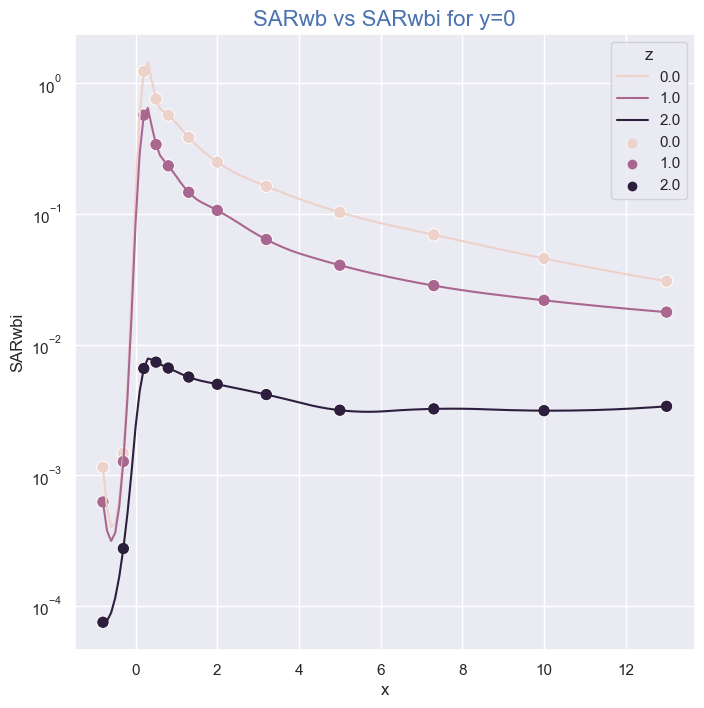

In [9]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
ym = 0
mask = (R.S.y == ym) & (R.S.z.isin([0,1,2]))

sn.lineplot(data=R.S[mask],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='x',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_title(f'SARwb vs SARwbi for y={ym}', fontsize=16, color='b');

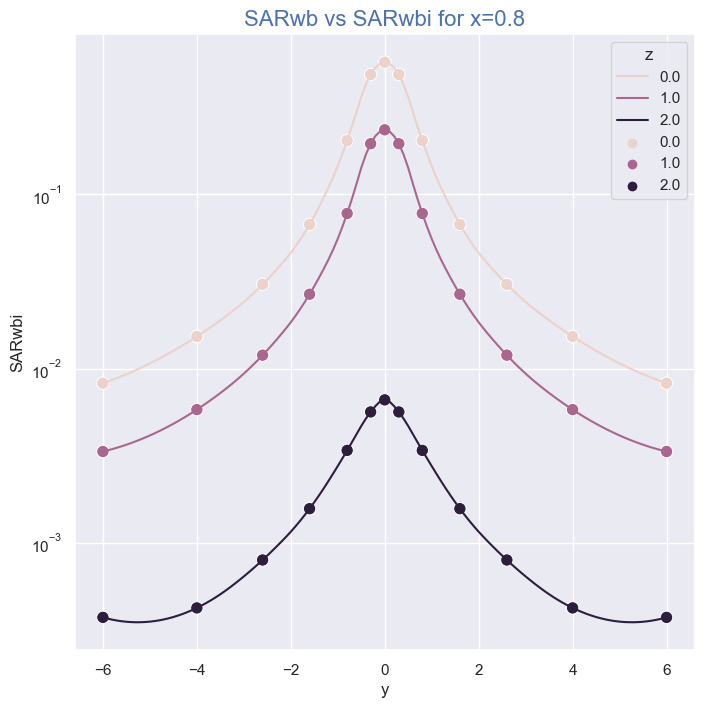

In [10]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(8, 8))
xm = 0.8
mask = (R.S.x == xm) & (R.S.z.isin([0,1,2]))

sn.lineplot(data=R.S[mask],x='y',y='SARwbi',hue='z')
sn.scatterplot(data=R.S[mask],x='y',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_title(f'SARwb vs SARwbi for x={xm}', fontsize=16, color='b');

### View public and occ compliance zones

In [10]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.ExclusionZone(
    data=["SE", "SE"],
    power=[200, 200],
    color=["gold", "red"],
    alpha=[0.5, 0.8],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    title="RPS S-1 public and occupational exclusion zones for FEKO SE data",
    figsize=(1200,800),
    axv=[True,False,True]
)

dat='SE', con=4.5
dat='SE', con=22.5
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=200, setting=occupational, limit=22.5 W/m², contour level=22.500


In [14]:
# Animated 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
R.AnimatedExclusionZone(
    data=["SE", "SE"],
    power=[50, 50],
    color=["gold", "red"],
    alpha=[0.5, 0.5],
    setting=["public", "occupational"],
    standard=["RPS S-1 WB"] * 2,
    ycut=0,
    daz=-0.1,
    elevation = 80,
    distance=None,
    title="",
    figsize=(1200,800),
    antenna=RFcalcUC.panelAntenna,
    axv=[False,False,False]
)

dat='SE', con=18.0
dat='SE', con=90.0
power=200, plotpower=50, setting=public, limit=4.5 W/m², contour level=18.000
power=200, plotpower=50, setting=occupational, limit=22.5 W/m², contour level=90.000


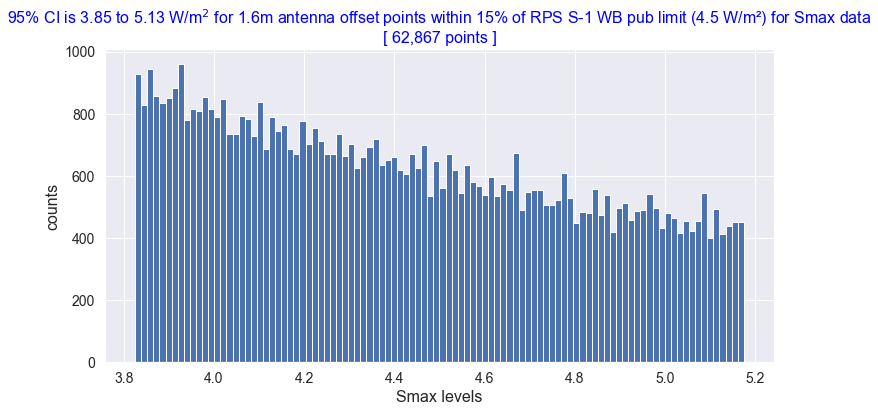

In [15]:
# Show SARwbi histogram
f = fsa16
f = R.sf('cb', offset=1.6, setting='pub')
R.hist(data='Smax', f=f, bins=100)

## Create spatially averaged fields
Create some new S columns for vertical spatial averaging

**c** is the convolution vector applied to z columns of points for each (x,y) group

For **Simpson's 1/3 rule**, the number of subintervals must be a multiple of **2**

For **Simpson's 3/8 rule**, the number of subdivisions must be divisible by **3**

In [9]:
def conv_vector(l, dl, m):
    '''Create a convolution vector
        l = length of convolution vector (m)
       dl = increment spacing between points in convolution vector (m)
        m = number of averaging points in convolution vector'''

    n = int(round(l/dl)) + 1  # number of points in convolution vector'''
    c = np.ones(n)            # convolution vector
    ix = np.arange(n)         # index of convolution vector
    dix = (n-1)/(m-1)         # index spacing between convolution averaging points

    assert round(l/dl,0) == round(l/dl,1), f'dl ({dl}) does not divide equally into l ({l})'
    assert type(m) == int, f'm ({m}) must be an integer'
    assert (n-1) % (m-1) == 0, f'm ({m}) does not distribute evenly across number of convolution points ({n})'

    c[(ix % dix) != 0] = 0
    c = c/m

    assert np.isclose(sum(c), 1, rtol=1e-08), f'sum of c ({sum(c)}) does not add up to 1'
    
    return c

In [10]:
# 1.6m vertical average curves
l, dl = 1.6, 0.1
for m in [17,5,3]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


17 points: sum[0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059, 0.059] = 1.0
creating SE-1.6m-17 spatial average of SE
creating Smax-1.6m-17 spatial average of Smax

 5 points: sum[0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.2] = 1.0
creating SE-1.6m-5 spatial average of SE
creating Smax-1.6m-5 spatial average of Smax

 3 points: sum[0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333] = 1.0
creating SE-1.6m-3 spatial average of SE
creating Smax-1.6m-3 spatial average of Smax


In [11]:
# 1.6m vertical average curves using Simpsons 1/3 rule
l = 1.6
c17 = [1,4,2,4,2,4,2,4,2,4,2,4,2,4,2,4,1]
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
c3  = [1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,1]
for m,clist in zip([3,5,17],[c3,c5,c17]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}-S13", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
    R.spatavg(f"Smax-{l}m-{m}-S13", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3))")


 3 points: sum[0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167] = 0.9999999999999999
creating SE-1.6m-3-S13 spatial average of SE
creating Smax-1.6m-3-S13 spatial average of Smax

 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-1.6m-5-S13 spatial average of SE
creating Smax-1.6m-5-S13 spatial average of Smax

17 points: sum[0.021, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.042, 0.083, 0.021] = 1.0
creating SE-1.6m-17-S13 spatial average of SE
creating Smax-1.6m-17-S13 spatial average of Smax


In [12]:
# 1.6m vertical average curves using Simpsons 1/3 rule and SH
l = 1.6
c5  = [1,0,0,0,4,0,0,0,2,0,0,0,4,0,0,0,1]
for m,clist in zip([5],[c5]):
    dl = l / (m-1)
    c = (1/3)*(dl/l) * np.array(clist)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SH-{l}m-{m}-S13", "SH", c, title=f"FEKO SH levels ({m} points averaged over {l}m (Simpson 1/3))")


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SH-1.6m-5-S13 spatial average of SH


In [13]:
# 1.5m vertical average curves using Simpsons 3/8 rule on 7 points
# Note: had to approximate values at 0.25,0.75,1.25 with 
# averages of (0.2,0.3), (0.7,0.8), (1.2,1.3)
l = 1.5
m = 7
dl = l / (m-1)
#      0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5
c6  = [1, 0, 1.5,1.5, 0,  3,  0,  1,  1,  0,  3,  0, 1.5,1.5, 0,  1]
c = (3/8)*(dl/l) * np.array(c6)
print(f'\n{m:2d} points: sum{list(c)} = {sum(c)}')
R.spatavg(f"SE-{l}m-{m}-S38", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 3/8))")
R.spatavg(f"Smax-{l}m-{m}-S38", "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 3/8))")


 7 points: sum[0.0625, 0.0, 0.09375, 0.09375, 0.0, 0.1875, 0.0, 0.0625, 0.0625, 0.0, 0.1875, 0.0, 0.09375, 0.09375, 0.0, 0.0625] = 1.0
creating SE-1.5m-7-S38 spatial average of SE
creating Smax-1.5m-7-S38 spatial average of Smax


In [14]:
l = 1.6
dl = 0.4
c5list = [1,4,2,4,1]
c5 = dl/(3*l) * np.array(c5list)
l,dl,c5list,c5,c5.sum()

(1.6,
 0.4,
 [1, 4, 2, 4, 1],
 array([0.08333333, 0.33333333, 0.16666667, 0.33333333, 0.08333333]),
 0.9999999999999999)

In [15]:
# 2m vertical average curves
l, dl = 2, 0.1
for m in [21]:
    c = conv_vector(l, dl, m)
    print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
    R.spatavg(f"SE-{l}m-{m}", "SE", c, title=f"FEKO SE levels ({m} points averaged over {l}m)")
    R.spatavg(f"Smax-{l}m-{m}",  "Smax",  c, title=f"FEKO Smax levels ({m} points averaged over {l}m)")


21 points: sum[0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048, 0.048] = 1.0000000000000004
creating SE-2m-21 spatial average of SE
creating Smax-2m-21 spatial average of Smax


In [16]:
# 2m vertical average curves using Simpsons 1/3 rule on 5 points
l = 2
m = 5
dl = l / (m-1)
#     0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.0
c7 = [1, 0,  0,  0,  0,  4,  0,  0,  0,  0,  2,  0,  0,  0,  0,  4,  0,  0,  0,  0,  1]
c = (1/3)*(dl/l) * np.array(c7)
print(f'\n{m:2d} points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-{l}m-{m}",  "SE",  c,title=f"FEKO SE levels ({m} points averaged over {l}m (Simpson 1/3))")
R.spatavg(f"Smax-{l}m-{m}","Smax",c,title=f"FEKO Smax levels ({m} points averaged over {l}m (Simpson 1/3)")


 5 points: sum[0.083, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.0, 0.083] = 0.9999999999999999
creating SE-2m-5 spatial average of SE
creating Smax-2m-5 spatial average of Smax


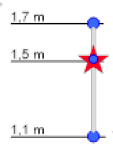

In [17]:
# IEC 62232 spatial averaging scheme (3pts over 0.6m)
c = np.array([1,0,0,0,1,0,1,0,0]) / 3
print(f'{len(c) = } points: sum{list(c.round(3))} = {sum(c)}')
R.spatavg(f"SE-IEC-0.6m-3", "SE", c, title=f"FEKO SE levels (IEC 3pt scheme over 0.6m)")
R.spatavg(f"Smax-IEC-0.6m-3", "Smax", c, title=f"FEKO Smax levels (IEC 3pt scheme over 0.6m)")

len(c) = 9 points: sum[0.333, 0.0, 0.0, 0.0, 0.333, 0.0, 0.333, 0.0, 0.0] = 1.0
creating SE-IEC-0.6m-3 spatial average of SE
creating Smax-IEC-0.6m-3 spatial average of Smax


In [18]:
R.datatitles

{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)',
 'SE-1.6m-17': 'FEKO SE levels (17 points averaged over 1.6m)',
 'Smax-1.6m-17': 'FEKO Smax levels (17 points averaged over 1.6m)',
 'SE-1.6m-5': 'FEKO SE levels (5 points averaged over 1.6m)',
 'Smax-1.6m-5': 'FEKO Smax levels (5 points averaged over 1.6m)',
 'SE-1.6m-3': 'FEKO SE levels (3 points averaged over 1.6m)',
 'Smax-1.6m-3': 'FEKO Smax levels (3 points averaged over 1.6m)',
 'SE-1.6m-3-S13': 'FEKO SE levels (3 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-3-S13': 'FEKO Smax levels (3 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-5-S13': 'FEKO SE levels (5 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-5-S13': 'FEKO Smax levels (5 points averaged over 1.6m (Simpson 1/3))',
 'SE-1.6m-17-S13': 'FEKO SE levels (17 points averaged over 1.6m (Simpson 1/3))',
 'Smax-1.6m-17-S13': 'FEKO Smax levels (17 poi

## Compare compliance zones

R essentially indicates the level of over-estimating WBA SAR compliance when conforming with the S limits. R ≥ 1 at an assessment point implies that WBA SAR will be compliant if S is compliant at that point and so it is desirable that R is always greater than or equal to 1.

#### WBA SAR vs all S settings

In [17]:
# Compare SAR, Smax
n = 6
R.ExclusionZone(
    data=["SARwbi","Smax","Smax-1.6m-17","Smax-1.6m-5","Smax-1.6m-3","Smax-IEC-0.6m-3"],
    power=[80] * n,
    color=["magenta","lightgrey","green","blue","brown","olive"],
    alpha=[1,0.5,0.5,0.5,0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs S compliance zones",
    ycut=0,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax', con=11.25
dat='Smax-1.6m-17', con=11.25
dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-3', con=11.25
dat='Smax-IEC-0.6m-3', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs peak spatial Smax

In [13]:
# Compare SAR, Smax
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax"],
    power=[80] * n,
    color=["magenta","lightgrey"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### SE spatial average 2m over 3pts

In [32]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["Smax-2m-3","Smax-2m-3"],
    power=[200]*2,
    color=["yellow","red"],
    alpha=[0.5]*2,
    setting=["public","occ"],
    standard=["RPS S-1 WB"]*2,
    title="SE-2m-3 public and occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=4.5
dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=public, limit=4.5 W/m², contour level=4.500
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


In [33]:
# Compare SAR, Ssa 1.6m 17pts
n = 1
R.ExclusionZone(
    data=["Smax-2m-3"],
    power=[200],
    color=["red"],
    alpha=[0.5],
    setting=["occ"],
    standard=["RPS S-1 WB"],
    title="SE-2m-3 occ compliance zones",
    ycut=None,
    axv=(True,False,True),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-2m-3', con=22.5
power=200, plotpower=200, setting=occ, limit=22.5 W/m², contour level=22.500


#### WBA SAR vs Smax spatial average 1.6m over 17pts

In [33]:
# Compare SAR, Ssa 1.6m 17pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-17 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-17', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs Smax spatial average 1.6m over 5pts

In [16]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [10]:
# Show Ssa 1.6m 17pts for GitBook image
n = 1
R.ExclusionZone(
    data=["Smax-1.6m-17"],
    power=[80] * n,
    color=["blue"] * n,
    alpha=[0.4] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Gitbook image of compliance zone",
    ycut=None,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-17', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [11]:
# Show Smax for GitBook image
n = 1
R.ExclusionZone(
    data=["Smax"],
    power=[80] * n,
    color=["lightgrey"] * n,
    alpha=[0.5] * n,
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Gitbook image of compliance zone",
    ycut=None,
    axv=(False,False,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [15]:
# 3D view of public and occ exclusions zones (200W)
# Note how parameters for multiple exclusion zones are supplied in lists []
n = 2
R.AnimatedExclusionZone(
    data=["SARwbi","Smax-1.6m-5"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.3],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    ycut=None,
    daz=-0.2,
    elevation = 60,
    distance=None,
    title="",
    showtitle=True,
    figsize=(900,900),
    antenna=RFcalcUC.panelAntenna,
    axv=[False,False,False],
    bg='lightgrey',
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs Smax spatial average 1.6m over 3pts

In [41]:
# Compare SAR, Ssa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-3"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-3', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### WBA SAR vs SE spatial average 1.6m over 5pts

In [18]:
# Compare SAR, SEsa 1.6m 5pts
n = 2
R.ExclusionZone(
    data=["SARwbi","SE-1.6m-5"],
    power=[100] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs SE-1.6m-5 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.16
dat='SE-1.6m-5', con=9.0
power=200, plotpower=100, setting=public, limit=0.08 W/kg, contour level=0.160
power=200, plotpower=100, setting=public, limit=4.5 W/m², contour level=9.000


#### WBA SAR vs Smax IEC spatial average 0.6m over 3pts

In [40]:
# Compare SAR, Smax 1.6m 17pts Simpson
n = 2
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-17S"],
    power=[80] * n,
    color=["magenta","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-17S', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [42]:
# Compare Smax 1.6m 5pts, Smax 1.6m 17pts Simpson
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-17","Smax-1.6m-17S"],
    power=[80] * n,
    color=["blue","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-17', con=11.25
dat='Smax-1.6m-17S', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


In [43]:
# Compare Smax 1.6m 5pts, Smax 1.6m 5pts Simpson
n = 2
R.ExclusionZone(
    data=["Smax-1.6m-5","Smax-1.6m-5S"],
    power=[80] * n,
    color=["blue","green"],
    alpha=[0.5, 0.5, 0.5,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-IEC-0.6m-3 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='Smax-1.6m-5', con=11.25
dat='Smax-1.6m-5S', con=11.25
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### Simpsons 1/3 rule compliance zones for 1.6m

In [59]:
# Compare SAR, SEsa 1.6m 5pts
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.6m-5-S13", "Smax-1.6m-17-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.3,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.6m-5 using Simpsons 1/3 rule",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.6m-5-S13', con=11.25
dat='Smax-1.6m-17-S13', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


#### Simpsons 3/8 rule compliance zones for 1.5m over 7 pts

In [62]:
# Compare SAR, SEsa 1.5m 7pts
n = 3
R.ExclusionZone(
    data=["SARwbi","Smax-1.5m-7-S38", "Smax-1.6m-5-S13"],
    power=[80] * n,
    color=["magenta","green","blue"],
    alpha=[0.5, 0.5, 0.3,0.5],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="Whole body SAR vs Smax-1.5m-7 using Simpsons 3/8 rule",
    ycut=None,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white'
)

dat='SARwbi', con=0.2
dat='Smax-1.5m-7-S38', con=11.25
dat='Smax-1.6m-5-S13', con=11.25
power=200, plotpower=80, setting=public, limit=0.08 W/kg, contour level=0.200
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250
power=200, plotpower=80, setting=public, limit=4.5 W/m², contour level=11.250


## Compliance ratio for SARwbi

### Generate compliance ratio statistic, R
$R$ is the ratio of the limit-normalized S exposure relative to the limit-normalized WBA SAR:

$\Large R = \frac{S/S_{lim}}{SAR_{wb}/SAR_{lim}}\; \; \; \; \; \; \; (Eq. 1)$

$R$ essentially indicates the level of over-estimating WBA SAR compliance when applying S limits.

Note that $R \geq 1 \Rightarrow$ WBA SAR is compliant if S is compliant

In [21]:
# Limits at 900 MHz
Slim = 4.5
SARlim = 0.08

# Create list of fields and associated filters for R ratios
sflist = [['Smax',f_outant],
          ['Smax-1.6m-17-S13',f_sa16nearfar],
          ['Smax-1.6m-3',f_sa16nearfar],
          ['Smax-1.6m-5',f_sa16nearfar],
          ['Smax-1.6m-3-S13',f_sa16nearfar],
          ['Smax-1.6m-5-S13',f_sa16nearfar],
          ['SE-1.6m-5-S13',f_sa16nearfar],
          ['SH-1.6m-5-S13',f_sa16nearfar]]

# Create S columns for R ratios
for Si,f in sflist:
    cr = (R.S[Si]/Slim) / (R.S.SARwbi/SARlim) 
    crname = f'{Si} SARwbi compliance ratio' 
    R.addS(cr, crname, f'Ratio of {Si} compliance to SARwbi compliance')

    dBcr = 10. * np.log10((R.S[Si]/Slim) / (R.S.SARwbi/SARlim))
    dBcrname = f'dB {Si} SARwbi compliance ratio' 
    R.addS(dBcr, dBcrname, f'dB Ratio of {Si} compliance to SARwbi compliance')

# Create list of Slist column names for compliance ratios
Slist = [s[0] for s in sflist]  # get a list of the S cols
dtlist =   [dt for scol in Slist for dt in R.datatitles if scol+' ' in dt and 'compliance' in dt and 'dB' not in dt]
dtdBlist = [dt for scol in Slist for dt in R.datatitles if scol+' ' in dt and 'compliance' in dt and 'dB' in dt]

### R histograms

#### R histogram function

In [35]:
# Function to draw histograms of limit normalised ratios of Smax vs WBA SAR
def histR(sflist,dtlist,cols=2):
    nS = len(dtlist)
    rows = int(np.ceil(nS/cols))
    letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    
    # Create labels for R or dB(R) cases
    dB = True if 'dB' in dtlist[0] else False 
    if dB:
        xlabel = 'dB(R)'
        cisuffix = ' dB'
        bins = np.linspace(-3,6,51)
    else:
        xlabel = 'R'
        cisuffix = ''
        bins = np.linspace(0,6,51)
        
    # Set the figsize according to number of rows
    if cols == 2:
        figsize = (10,18)
    elif cols == 3:
        figsize = (15,16)
    elif cols == 4:
        figsize = (18,10)
    else:
        figsize = (16,16)
    
    # Create figure and axes
    fig, axes = plt.subplots(rows,cols,figsize=figsize,sharey=True)
    axes = axes.flatten()
    
    # Create histogram plots in axes 
    for i, (s,f) in enumerate(sflist):
        dt = dtlist[i]       
        data = R.S.loc[f.mask,dt].dropna()
        axes[i].hist(data,bins=bins,density=True)
        axes[i].set_title(s, fontsize=15, color='g',fontweight="bold")
        axes[i].set_xlim(bins[0],bins[-1])
        ci = np.percentile(data,[2.5,97.5]).round(2)
        mean = data.mean().round(2)
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}\n$\\mu$ = {mean}{cisuffix}' 
        text = f'95% CI = {ci[0]}, {ci[1]}{cisuffix}' 
        if i % 2 == 0:
            axes[i].set_ylabel('normalised counts',fontsize=14)
        if dB:
            axes[i].axvline(x=0, color='r',ls='--')
            axes[i].text(0.04, 0.9, text, horizontalalignment='left',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            axes[i].text(0.04, 0.82, tr.fill(f.name,width=25), horizontalalignment='left',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=14, color='b')
        else:
            axes[i].axvline(x=1, color='r',ls='--')
            axes[i].text(0.96, 0.9, text, horizontalalignment='right',
                         verticalalignment='center', transform=axes[i].transAxes,
                         fontsize=14, color='b')
            axes[i].text(0.96, 0.84, tr.fill(f.name,width=25), horizontalalignment='right',
                             verticalalignment='top', transform=axes[i].transAxes,
                             fontsize=14, color='b')

        axes[i].set_xlabel(xlabel, fontsize=14)
        axes[i].text(0.08, 0.92, letters[i], horizontalalignment='center', fontsize=18,
                     verticalalignment='center', transform=axes[i].transAxes)
        
    # Finish off decorating the figure
    if nS != rows * cols: axes[-1].remove()
    title = 'Limit normalised ratios of S vs WBA SAR:  $R = \\frac{S/S_{lim}}{SAR/SAR_{lim}}$\n'
    fig.suptitle(title, fontsize=20)
    fig.tight_layout(h_pad=1)
    
def showstats(dtlist,sflist):
    table = []
    for (dt,sf) in zip(dtlist,sflist):
        f = sf[1]
        data = R.S.loc[f.mask,dt].dropna()
        count = len(data)
        ci = np.percentile(data,[2.5,50,97.5]).round(2)
        mean = data.mean().round(2)
        std = data.std().round(2)
        minval = data.min().round(2)
        maxval = data.max().round(2)
        table.append([dt,count,mean,std,minval,ci[0],ci[1],ci[2],maxval])
    df = pd.DataFrame(table,columns=('data','count','mean','std','min','2.5%','50%','97.5%','max'))
    
    return df.set_index('data')

#### R histogram for all valid points

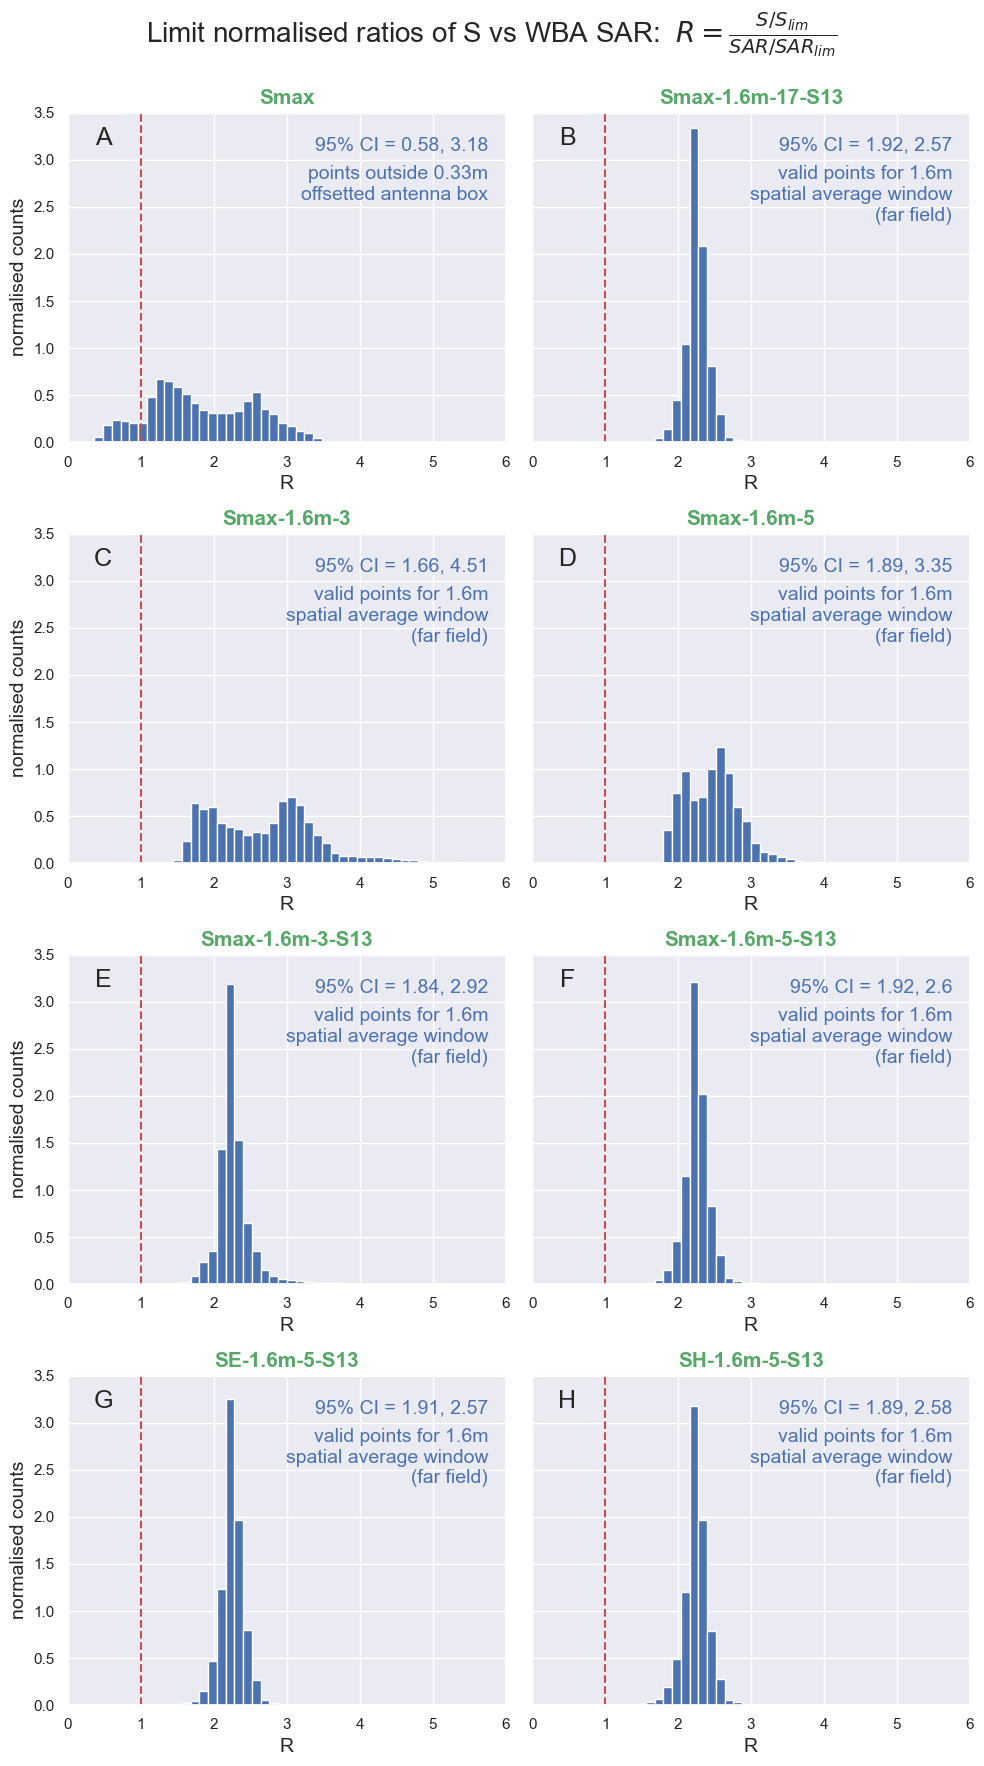

In [36]:
histR(sflist,dtlist,cols=2)
plt.savefig(plotdir + 'R histogram panel.png', dpi=150)

In [68]:
showstats(dtlist,sflist)

,count,mean,std,min,2.5%,50%,97.5%,max
data,,,,,,,,
Smax SARwbi compliance ratio,689510,1.84,0.73,0.06,0.58,1.72,3.18,28.38
Smax-1.6m-17-S13 SARwbi compliance ratio,689462,2.26,0.26,0.25,1.92,2.24,2.57,41.93
Smax-1.6m-3 SARwbi compliance ratio,689462,2.72,0.97,0.16,1.66,2.74,4.52,205.83
Smax-1.6m-5 SARwbi compliance ratio,689462,2.49,0.54,0.20,1.89,2.49,3.36,123.82
Smax-1.6m-3-S13 SARwbi compliance ratio,689462,2.28,0.40,0.16,1.84,2.25,2.94,102.96
Smax-1.6m-5-S13 SARwbi compliance ratio,689462,2.26,0.27,0.19,1.92,2.24,2.60,52.00
SE-1.6m-5-S13 SARwbi compliance ratio,689462,2.25,0.25,0.12,1.91,2.23,2.57,38.92
SH-1.6m-5-S13 SARwbi compliance ratio,689462,2.25,0.26,0.09,1.88,2.23,2.58,51.64


In [69]:
# Get proportion of R < 1 values for Smax 
SmaxR = R.S['Smax SARwbi compliance ratio'].dropna()
nall = len(SmaxR)              # count of all not null R values
nlowR = len(SmaxR[SmaxR < 1])  # count of R values < 1
nlowR / nall

0.11796327904417044

#### dB(R) histograms for all valid points

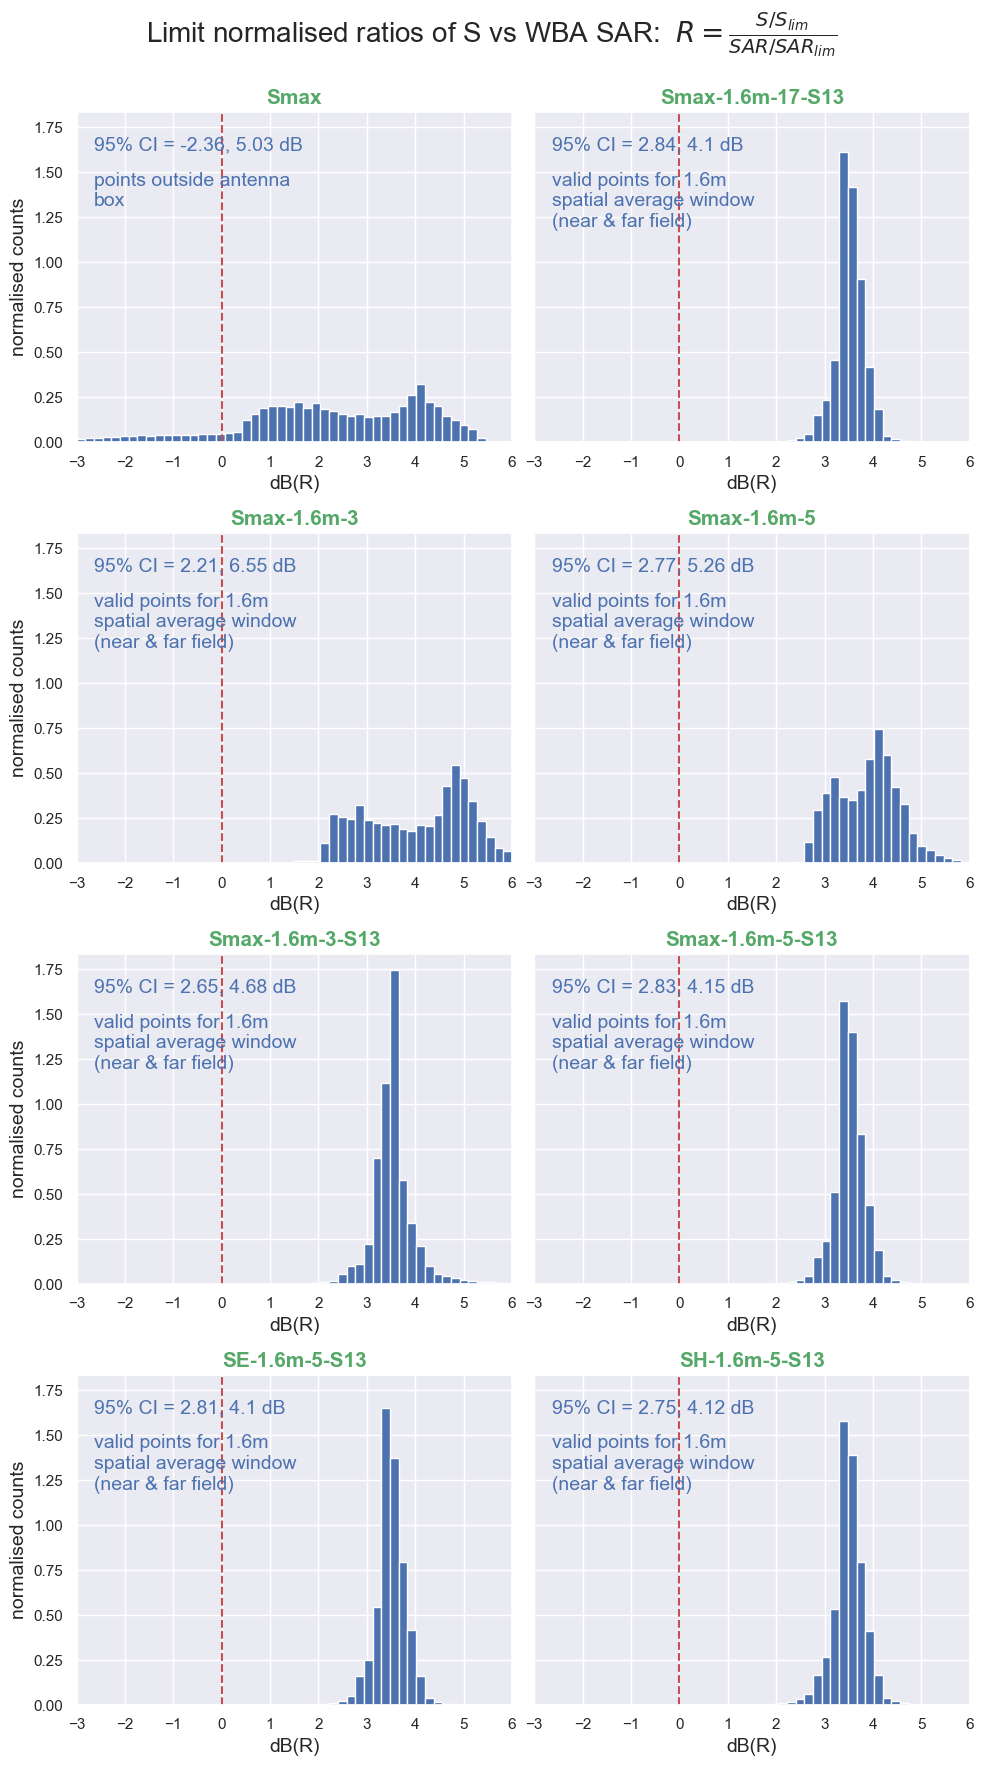

In [65]:
# dB(R) histograms for Slist
histR(sflist,dtdBlist,cols=2)
plt.savefig(plotdir + 'dB(R) histogram panel.png', dpi=150)

#### R histograms for valid points in near field (<1$\lambda$)

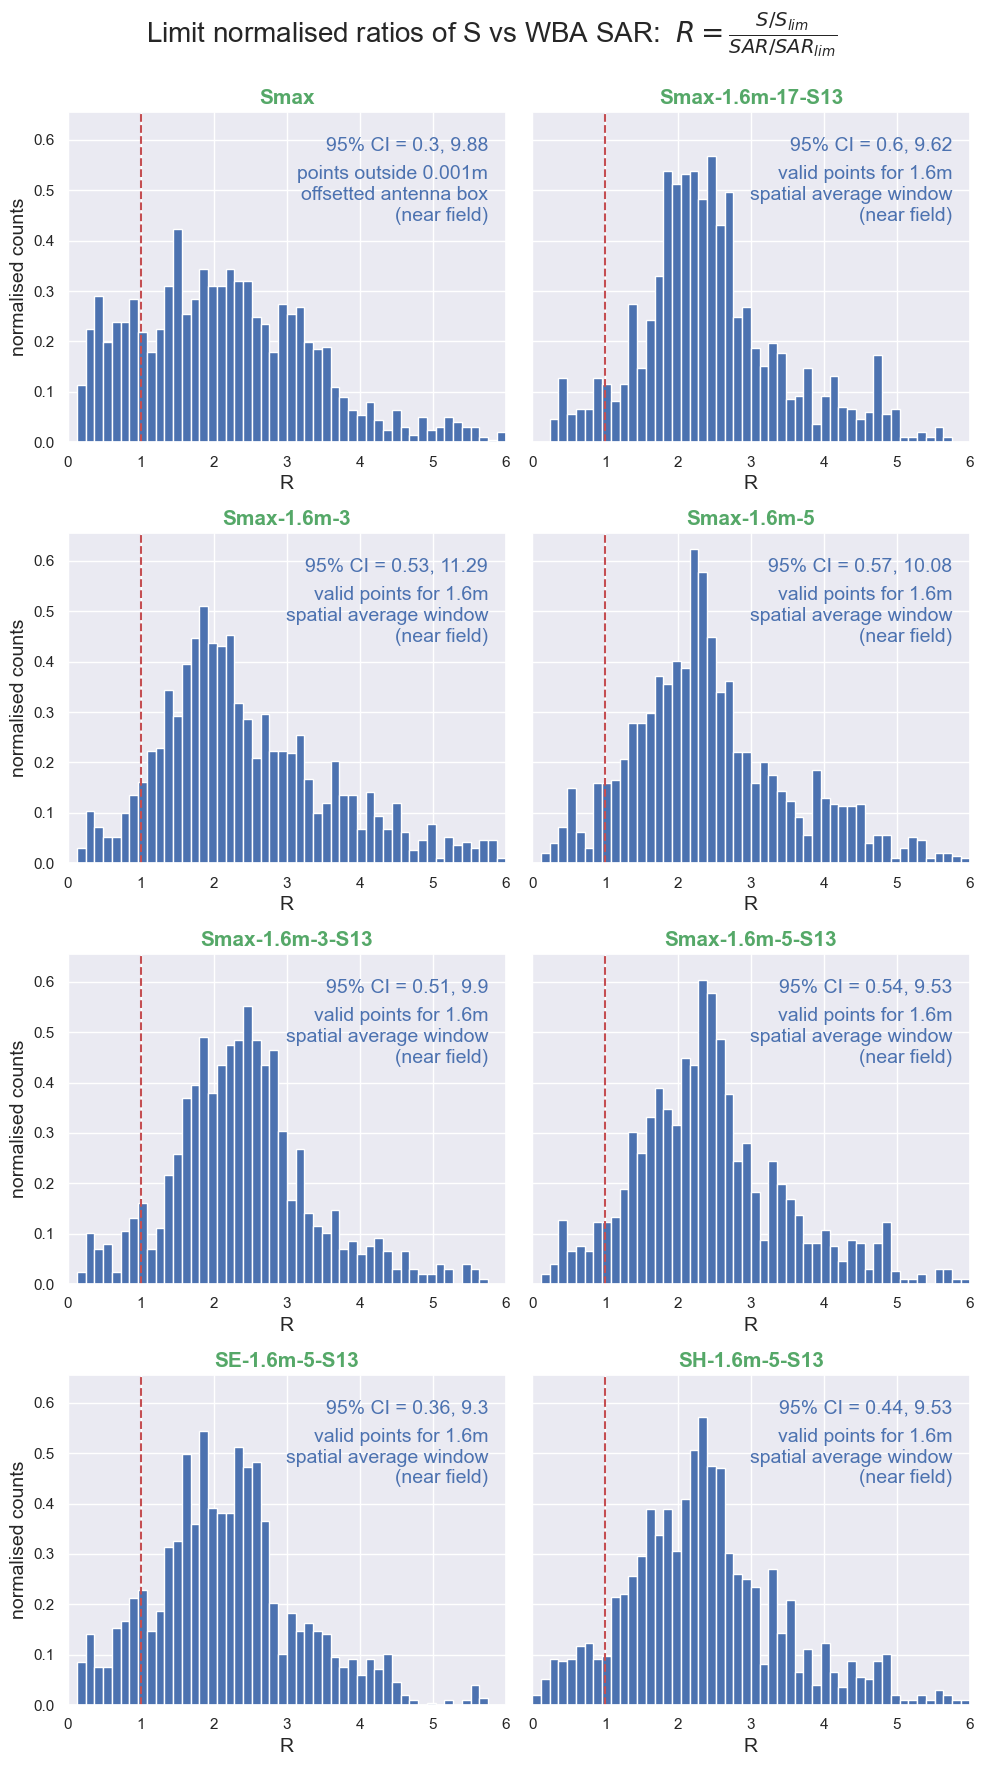

In [23]:
sflist = [['Smax',f_outantnear],
          ['Smax-1.6m-17-S13',f_sa16near],
          ['Smax-1.6m-3',f_sa16near],
          ['Smax-1.6m-5',f_sa16near],
          ['Smax-1.6m-3-S13',f_sa16near],
          ['Smax-1.6m-5-S13',f_sa16near],
          ['SE-1.6m-5-S13',f_sa16near],
          ['SH-1.6m-5-S13',f_sa16near]]

histR(sflist,dtlist,cols=2)
plt.savefig(plotdir + 'R histogram panel near.png', dpi=150)

#### R histograms for valid points in far field (> 1$\lambda$)

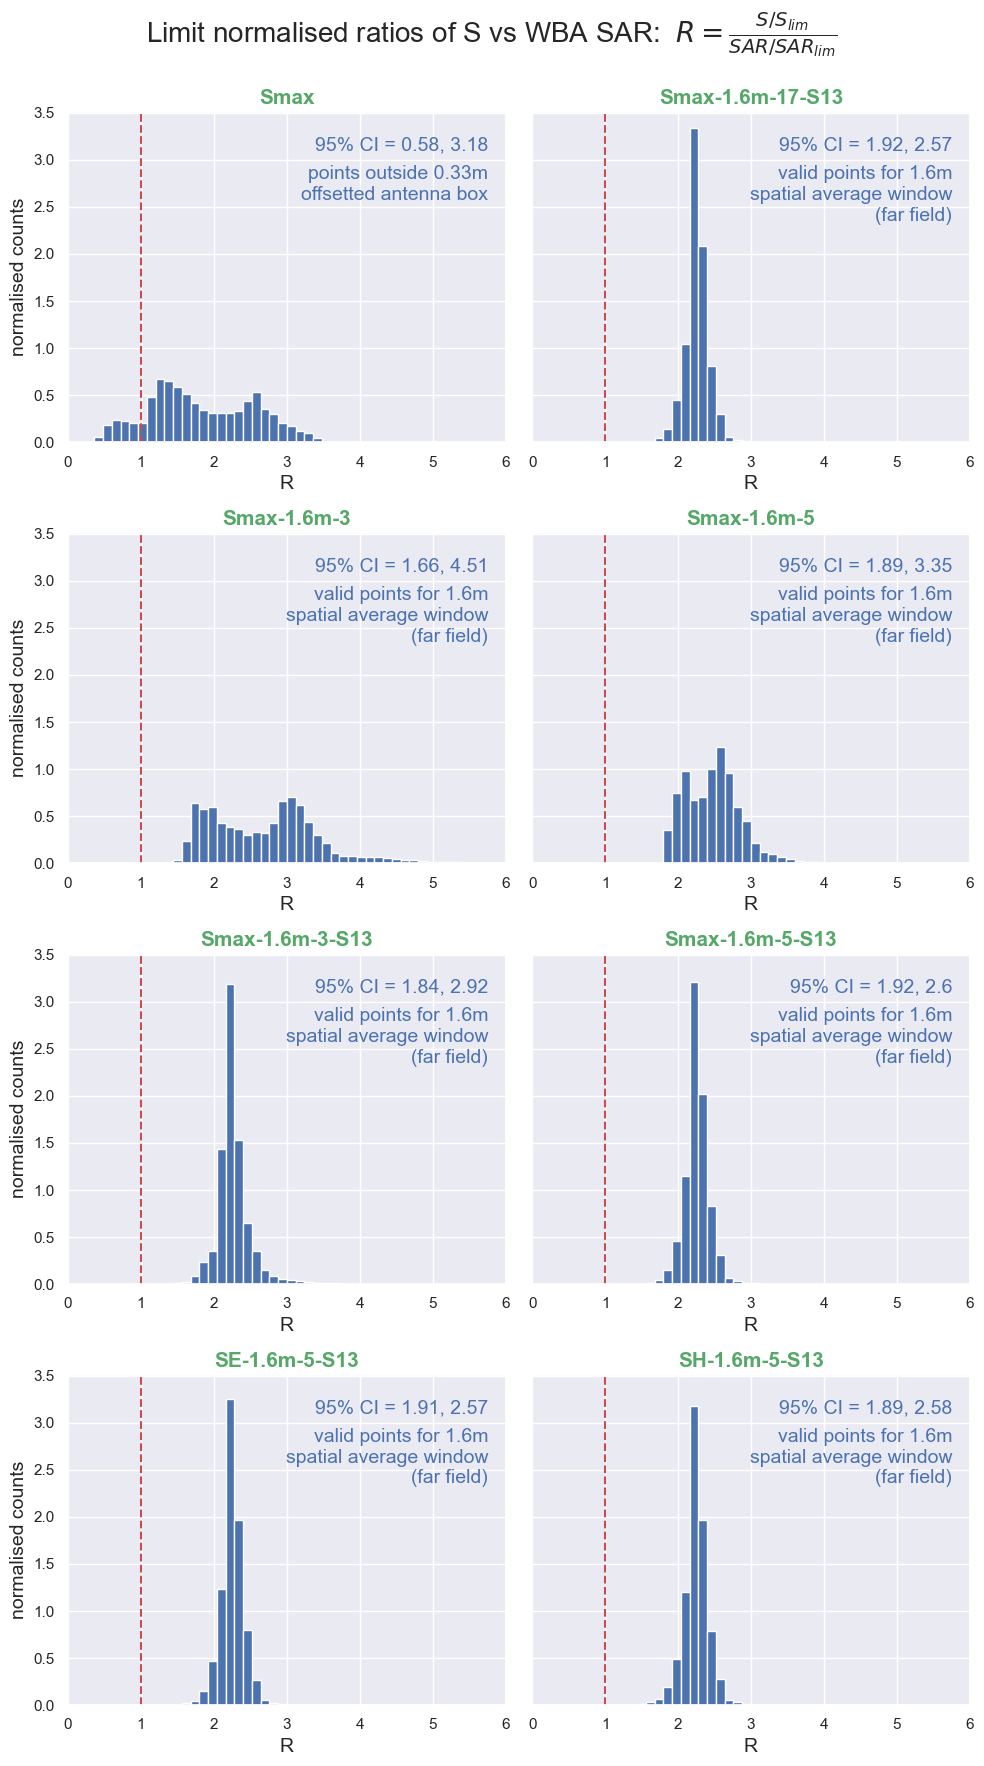

In [25]:
sflist = [['Smax',f_far],
          ['Smax-1.6m-17-S13',f_sa16far],
          ['Smax-1.6m-3',f_sa16far],
          ['Smax-1.6m-5',f_sa16far],
          ['Smax-1.6m-3-S13',f_sa16far],
          ['Smax-1.6m-5-S13',f_sa16far],
          ['SE-1.6m-5-S13',f_sa16far],
          ['SH-1.6m-5-S13',f_sa16far]]

histR(sflist,dtlist,cols=2)
plt.savefig(plotdir + 'R histogram panel near.png', dpi=150)

#### Kolmogorov-Smirnov test for outant points

In [22]:
ks_table = R.S.loc[fsa16.mask,dtlist+dtdBlist].dropna().agg(stats.kstest, cdf='norm').T
ks_table.columns = ['KS statistic','p-value']
ks_table

,KS statistic,p-value
Smax SARwbi compliance ratio,0.725872,0.0
Smax-1.6m-17 SARwbi compliance ratio,0.968015,0.0
Smax-1.6m-5 SARwbi compliance ratio,0.962654,0.0
Smax-1.6m-3 SARwbi compliance ratio,0.938272,0.0
SE-1.6m-5 SARwbi compliance ratio,0.961369,0.0
Smax-IEC-0.6m-3 SARwbi compliance ratio,0.799956,0.0
dB Smax SARwbi compliance ratio,0.613466,0.0
dB Smax-1.6m-17 SARwbi compliance ratio,0.994521,0.0
dB Smax-1.6m-5 SARwbi compliance ratio,0.992871,0.0
dB Smax-1.6m-3 SARwbi compliance ratio,0.972743,0.0


<u>Notes</u>:

+ The p value signifies the likelihood of the null hypothesis, i.e. that the distribution is normal
+ The p values are 0 because of the very large number of points (1,298,751) in the distributions
+ the KS statistic shows that the **dB(R)** distributions for the 1.6m spatial averages of S are marginally more normal than the **R** distributions as their KS statistics are marginally higher. 

### R vs r

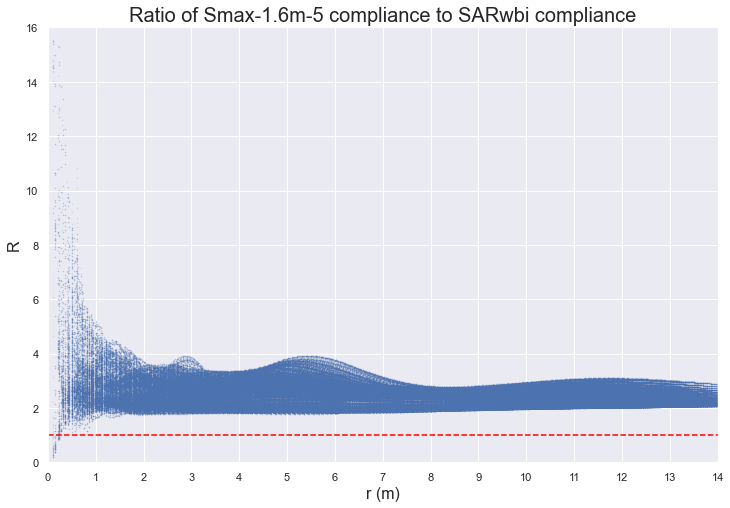

In [27]:
Ssa = 'Smax-1.6m-5 SARwbi compliance ratio'
mask = fsa16.mask
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r'], y=R.S.loc[mask,Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((0,16))
ax.set_xticks(range(15))
ax.hlines(1,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'R vs r scatter ({Ssa}) valid 1.6m points panel.png')

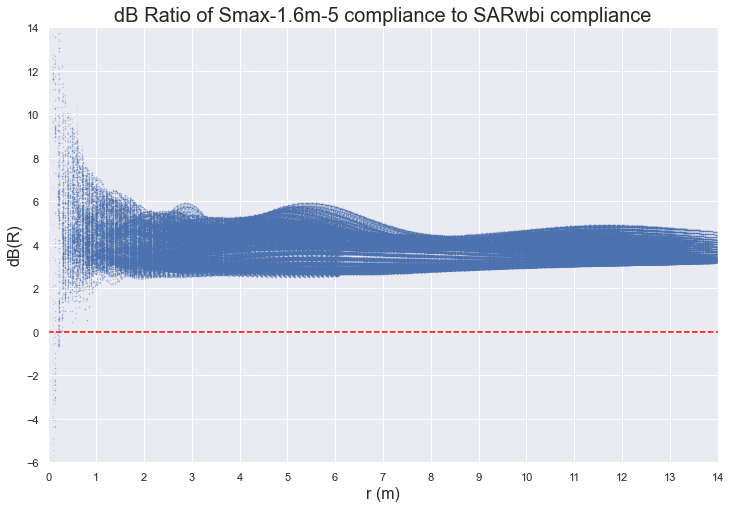

In [28]:
Ssa = 'dB Smax-1.6m-5 SARwbi compliance ratio'
mask = fsa16.mask
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(x=R.S.loc[mask,'r'], y=R.S.loc[mask,Ssa],alpha=0.2,s=0.2);
ax.set_title(R.datatitles[Ssa],fontsize=20)
ax.set_xlabel('r (m)', fontsize=16)
ax.set_ylabel('dB(R)', fontsize=16)
ax.set_xlim((0,14))
ax.set_ylim((-6,14))
ax.set_xticks(range(15))
ax.set_yticks(range(-6,15,2))
ax.hlines(0,xmin=0,xmax=14,colors='red', linestyles='--')
fig.savefig(plotdir + f'dB(R) vs r scatter ({Ssa}).png')

In [22]:
Ssa = 'dB Smax-1.6m-5-S13 SARwbi compliance ratio'

R.msp(data=Ssa,f=f_near,mp=1,V=[-6,6],nlabels=9,ncolors=8, scale=0.1,
      antenna=RFcalcUC.panelAntenna,ctitle='dB(R)',standard='RPS S-1 WB')

## Point spatial vs spatial average uncertainty

In [19]:
# Compare SE and SE-1.6m-5
n = 2
R.ExclusionZone(
    data=["SE","SE-1.6m-5"],
    power=[40] * n,
    color=["lightgrey","green"],
    alpha=[0.7, 0.4],
    setting=["public"] * n,
    standard=["RPS S-1 WB"] * n,
    title="SE vs SE-1.6m-5 compliance zones",
    ycut=0,
    axv=(True,True,False),
    figsize=(1200,800),
    bg='white',
    antenna=RFcalcUC.panelAntenna,
)

dat='SE', con=22.5
dat='SE-1.6m-5', con=22.5
power=200, plotpower=40, setting=public, limit=4.5 W/m², contour level=22.500
power=200, plotpower=40, setting=public, limit=4.5 W/m², contour level=22.500


### Create error data column in R.S

In [33]:
# Create error data
err = R.S['SE'] / R.S['SE-1.6m-5']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-5', 'dB error for SE / SE-1.6m-5')

err = R.S['SE'] / R.S['SE-1.6m-5-S13']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-5-S13', 'dB error for SE / SE-1.6m-5-S13')

err = R.S['SE'] / R.S['SE-1.6m-17-S13']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE v SE-1.6m-17-S13', 'dB error for SE / SE-1.6m-17-S13')

err = R.S['SE-1.6m-5-S13'] / R.S['SE-1.6m-17-S13']
dBerr = 10. * np.log10(err)
R.addS(dBerr, 'dBerr SE-1.6m-5-S13 v SE-1.6m-17-S13', 'dB error for SE-1.6m-5-S13 / SE-1.6m-17-S13')

### Analyse all valid points

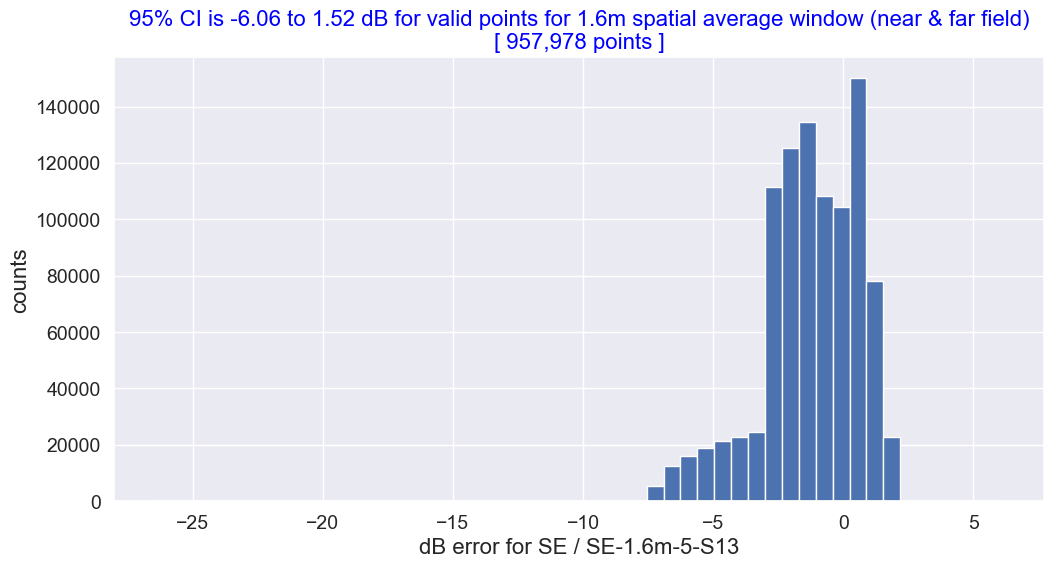

In [80]:
# R.hist(data='dBerr SE v SE-1.6m-5', f=f_sa16nearfar, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-5-S13', f=f_sa16nearfar, CI=95, bins=50)
# R.hist(data='dBerr SE v SE-1.6m-17-S13', f=f_sa16nearfar, CI=95, bins=100)
# R.hist(data='dBerr SE-1.6m-5-S13 v SE-1.6m-17-S13', f=f_sa16nearfar, CI=95, bins=100)

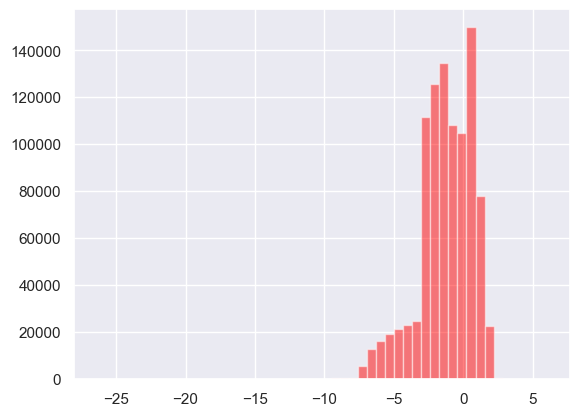

In [78]:
Nps = R.S.loc[f_sa16nearfar.mask,'dBerr SE v SE-1.6m-5-S13']
plt.hist(Nps,bins=50,alpha=0.5,color='red');

### Analyse points close to the antenna (within λ)

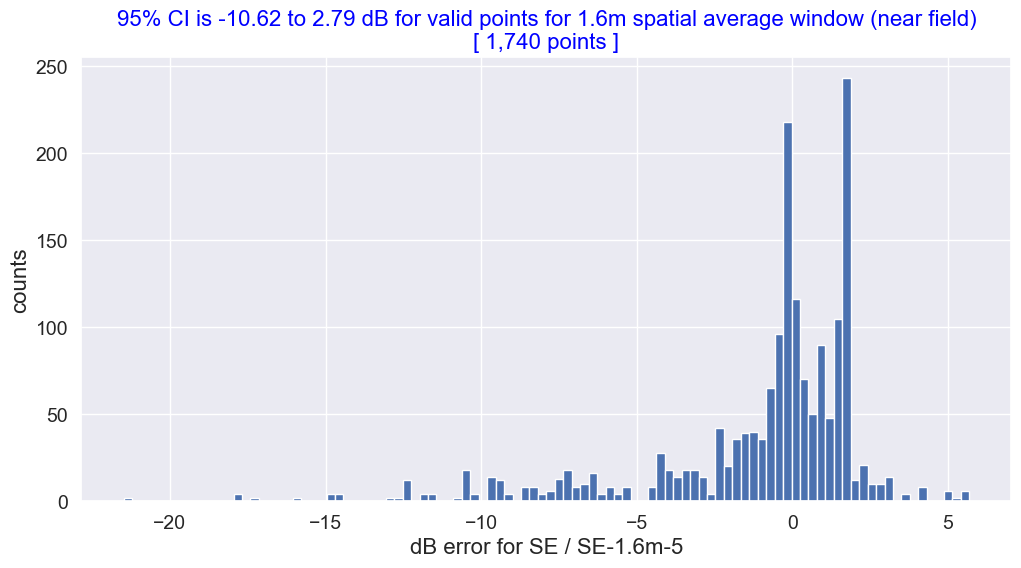

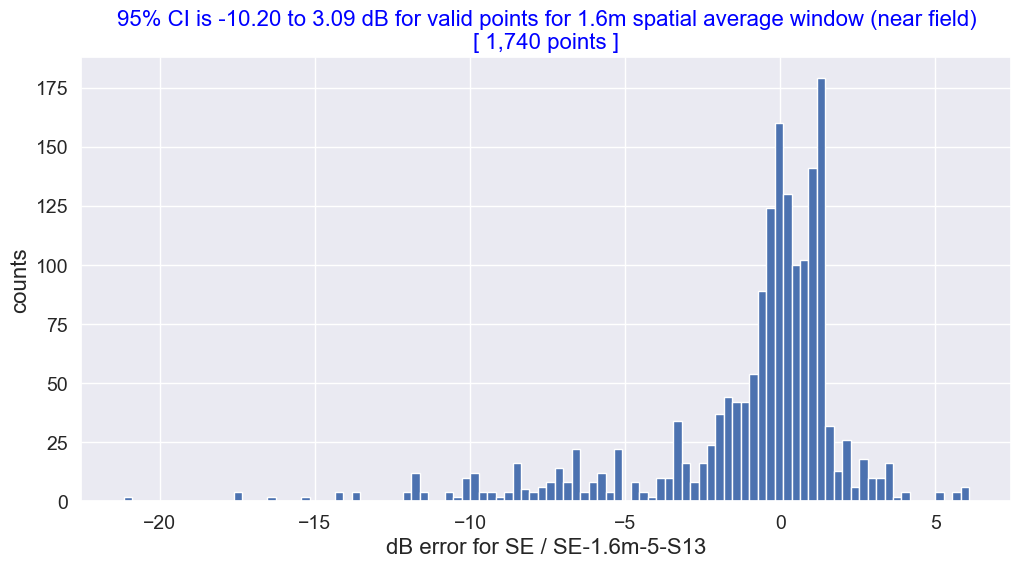

In [39]:
# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f_sa16near, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-5-S13', f=f_sa16near, CI=95, bins=100)

### Analyse points *not* close to the antenna (further than λ)

replacing z with S.z --> (S.z >= -2.2) & (S.z <= 2.2)
meval: (S.z >= -2.2) & (S.z <= 2.2)


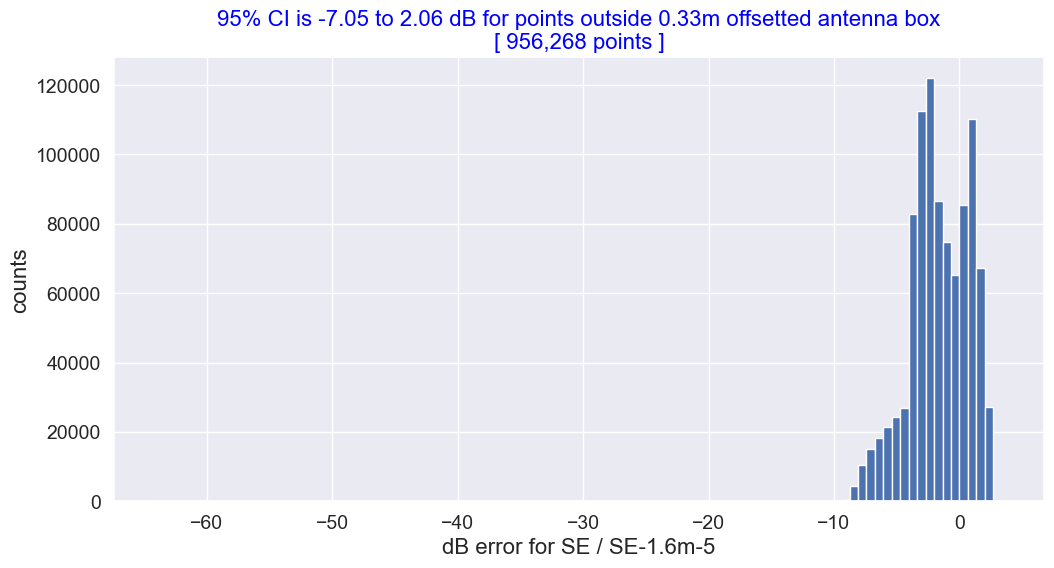

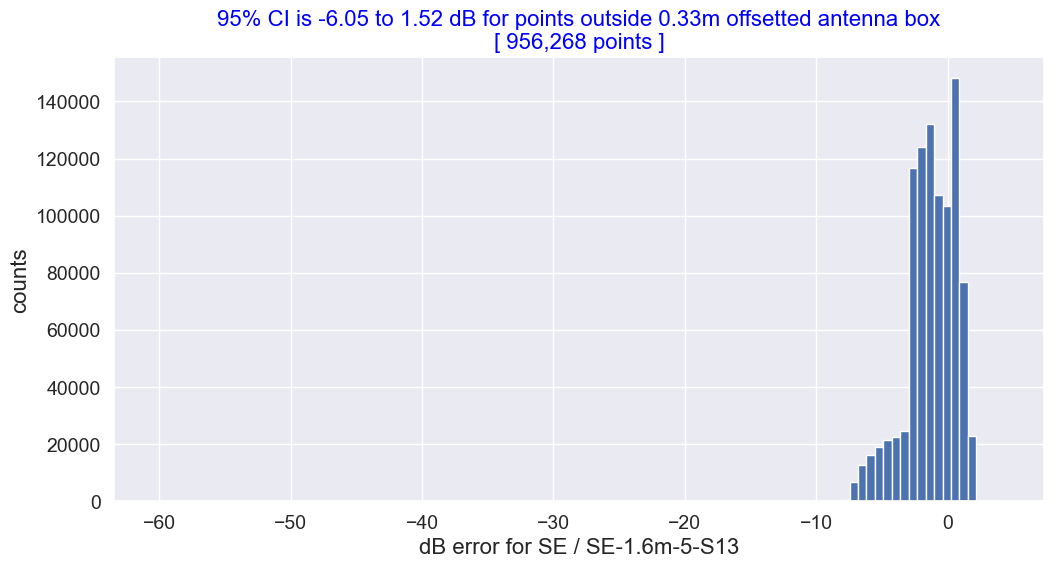

In [40]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f0 = R.sf('(z >= -2.2) & (z <= 2.2)')  # exclude points that aren't properly averaged
f2 = R.sf('outant', offset=d, setting='pub', power=100)
f2.mask = f2.mask & f0.mask

# Show SARwbi histogram
R.hist(data='dBerr SE v SE-1.6m-5', f=f2, CI=95, bins=100)
R.hist(data='dBerr SE v SE-1.6m-5-S13', f=f2, CI=95, bins=100)

# Show filter points
# R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
#       scale=0.025, antenna=RFcalcUC.panelAntenna, ctitle=None, standard='RPS S-1 WB')

### Analyse points *not* close to the antenna (further than λ)

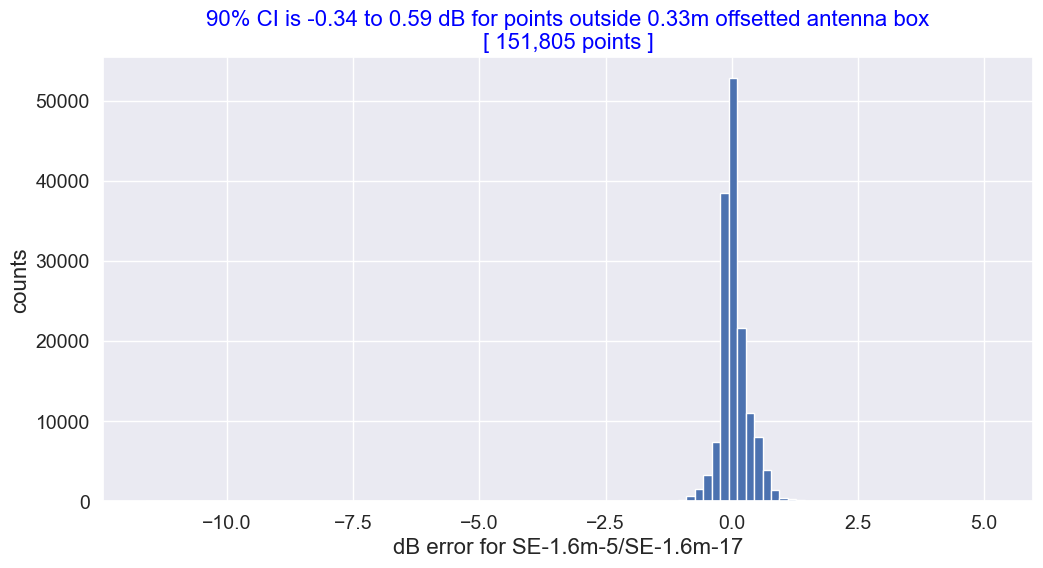

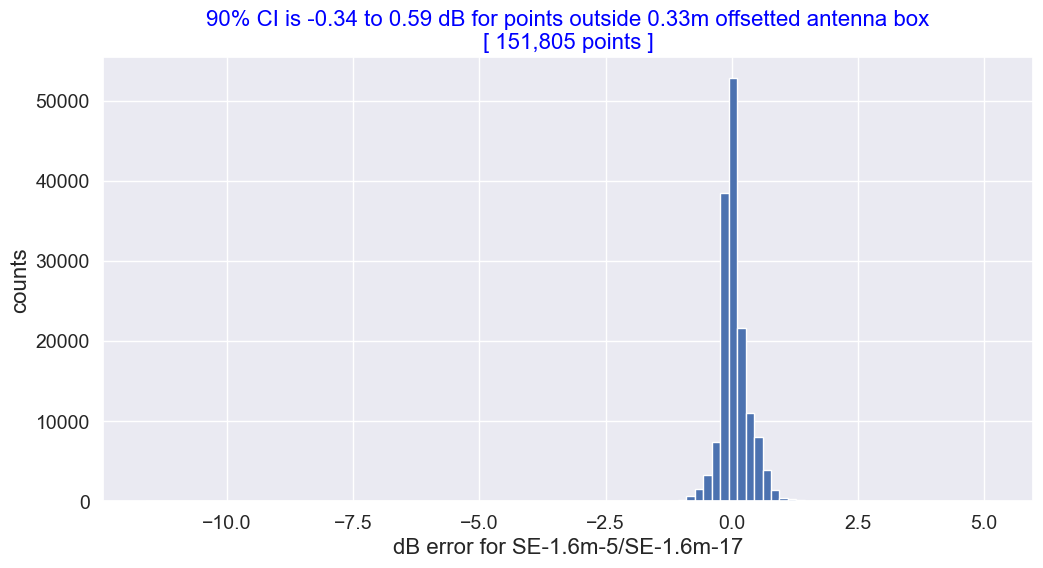

In [96]:
# Create filter for points
wl = 300 / R.freq  # wavelength
d = round(wl, 2)
f2 = R.sf('outant', offset=d, setting='pub', power=100)

# Show SARwbi histogram
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)
R.hist(data='dBerr SE-1.6m-5 v SE-1.6m-17', f=f2, CI=90, bins=100)

# Show filter points
# R.msp(data='dBerr SE v SE-1.6m-5', f=f2, mp=4, V=[-10, 10], nlabels=21, ncolors=8,
#       scale=0.025, antenna=RFcalcUC.panelAntenna, ctitle=None, standard='RPS S-1 WB')

### Uncertainty calcs

The triangular distribution can be represented with an up-sloping line from loc to (loc + c x scale) and then downsloping for (loc + c*scale) to (loc + scale).

triang takes c as a shape parameter for .

In [87]:
# Import python modules
import numpy as np
from scipy.stats import trapz, t, triang, norm, uniform

# Set no. of M-C trials to 1 million
n = 1_000_000

# Generate the random variate samples 
# for the input quantities, xi
Ptx = norm.rvs(loc=0,scale=0.1,size=n)
Lx = triang.rvs(c=0.5, loc=-1, scale=2, size=n)
Fs = uniform.rvs(loc=-2,scale=4,size=n) 
G = uniform.rvs(loc=-1.5,scale=3,size=n) 
NFAC = uniform.rvs(loc=-2,scale=4,size=n)
Nps = norm.rvs(loc=0,scale=1.835,size=n)
Nps_data = R.S.loc[f_sa16far.mask,'dBerr SE v SE-1.6m-5-S13']
Nps = np.random.choice(-Nps_data, size=n, replace=True)

# Create the combined dB distribution
# and calculate U95 percentiles
SeqdB = Ptx + Lx + Fs + G + NFAC + Nps
U95 = np.percentile(SeqdB, [2.5,97.5])
U90 = np.percentile(SeqdB, [5,95])
print(f"U90 = [{U90[0]:0.2f}dB, {U90[1]:0.2f}dB]")

U90 = [-2.93dB, 5.90dB]


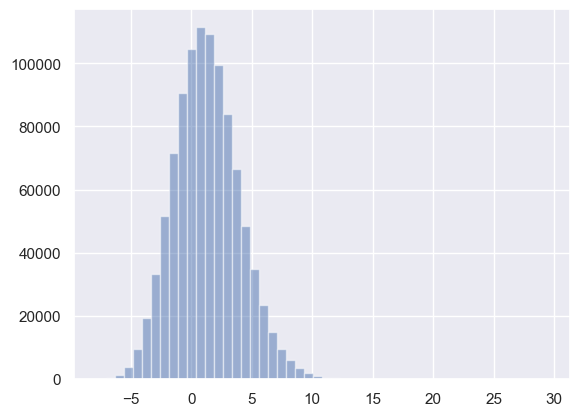

In [89]:
plt.hist(SeqdB,bins=50,alpha=0.5);

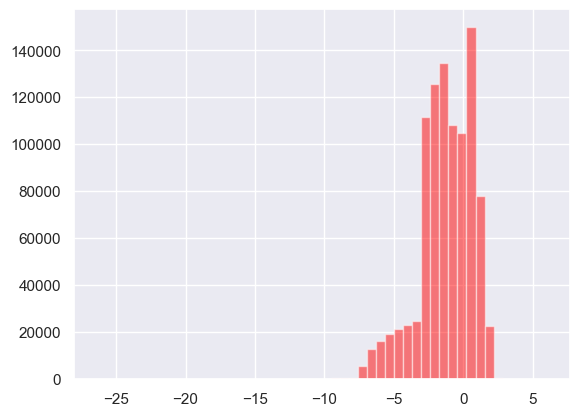

In [78]:
Nps = R.S.loc[f_sa16nearfar.mask,'dBerr SE v SE-1.6m-5-S13']
plt.hist(Nps,bins=50,alpha=0.5,color='red');

## Scratch

$\Large S_{avg, z_0} = \frac{\int_{z_0-L/2}^{z_0+L/2}{S(z) dz}}{L} \quad \text{(eq. 1)}$

$\Large S_{avg} = \frac{[S_0 + S_1 + S_2 + S_3 + S_4 + S_5]}{5}$

$\Large S_{avg} = \frac{\Delta z}{L}[\frac{1}{2}S_0 + S_1 + S_2 + S_3 + S_4 + \frac{1}{2}S_5]$

$\Large S_{avg} = \frac{\Delta z}{3L}[S_0 + 4S_1 + 2S_2 + 2S_3 + 4S_4 + S_5]$

In [41]:
def skewGrid():
    '''Show S and SAR grid points
    usage: .showgrids(S, SAR)
      S = flag to toggle S grid visibility (True/False)
    SAR = flag to toggle SAR grid visibility (True/False)
    hman = height of body model behind antenna in m
           If hman = None, then man model is not displayed
    avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
    '''
    # Make the grid
    x = [-0.8,-0.3,0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
    y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
    z = [-2,-1, 0, 1, 2]    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(900,900), bgcolor=(0.3, 0.3, 0.3))
    mlab.clf()

    # draw the SAR grid popints
    mlab.points3d(xx,yy,zz,scale_factor=0.1,color=(1,1,0),opacity=1)   # SAR grid

    # Add the antenna box
    RFcalcUC.panelAntenna('yellow')

    # Draw the scene
    fig.scene.parallel_projection = True
    mlab.show()
    
skewGrid()

In [42]:
a = pd.Series([1,2,3,np.nan])
display(a)
a.mean()

0    1.0
1    2.0
2    3.0
3    NaN
dtype: float64

2.0

KstestResult(statistic=0.02695698665017554, pvalue=0.45373481183512343)

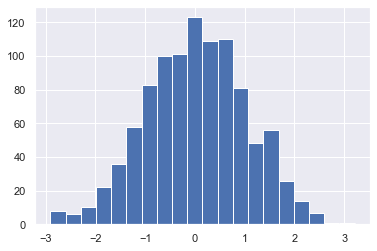

In [263]:
import numpy as np
from scipy import stats
np.random.seed(9)

my_data = stats.norm.rvs(size=1000)
plt.hist(my_data,bins=20);
stats.kstest(my_data, 'norm')

In [22]:
R.S['SARwbi'].dropna().size

689579

### Mayavi animations

In [4]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

In [2]:
import numpy as np
from mayavi import mlab
x, y = np.mgrid[0:3:1,0:3:1]
s = mlab.surf(x, y, np.asarray(x*0.1, 'd'))

@mlab.animate
def anim():
    for i in range(10):
        s.mlab_source.scalars = np.asarray(x*0.1*(i+1), 'd')
        yield

anim()
mlab.show()

In [6]:
# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

# View it.
l = mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')

# Now animate the data.
ms = l.mlab_source
for i in range(10):
    x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer + np.pi*(i+1)/5.)*0.5)
    scalars = np.sin(mu + np.pi*(i+1)/5)
    ms.trait_set(x=x, scalars=scalars)
    
mlab.show()

In [8]:
from mayavi import mlab
@mlab.animate(delay=100, ui=False)
def anim():
    f = mlab.gcf()
    while 1:
        f.scene.camera.azimuth(2)
        f.scene.render()
        yield

a = anim() # Starts the animation.
mlab.show()

In [10]:
import numpy as np
from mayavi import mlab

@mlab.animate(delay = 100)
def updateAnimation():
    t = 0.0
    while True:
        ball.mlab_source.set(x = np.cos(t), y = np.sin(t), z = 0)
        t += 0.1
        yield

ball = mlab.points3d(np.array(1.), np.array(0.), np.array(0.))

updateAnimation()
mlab.show()

In [29]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab
import numpy as np

# Produce some nice data.
n_mer, n_long = 6, 11
pi = np.pi
dphi = pi/1000.0
phi = np.arange(0.0, 2*pi + 0.5*dphi, dphi, 'd')
mu = phi*n_mer
x = np.cos(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
y = np.sin(mu)*(1+np.cos(n_long*mu/n_mer)*0.5)
z = np.sin(n_long*mu/n_mer)*0.5

@mlab.animate(delay = 50)
def updateAnimation():
    az = 0.0
    while True:
        mlab.view(azimuth=az, elevation=70,distance=10)
        az += 1
        yield

# View it.
fig = mlab.figure(1, size=(900,900), bgcolor=(1,1,1))
mlab.plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
updateAnimation()
mlab.show()

### Fast start

In [8]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

# import other modules
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from tqdm import tqdm
from scipy import stats
from scipy import interpolate
from collections import namedtuple
import textwrap as tr
import pandas as pd
import RFcalcUC_v11 as RFcalcUC
from matplotlib.ticker import StrMethodFormatter
pd.set_option('display.max_rows', 180)
from icecream import ic

# Set plotting environment
sn.set()

# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# Set trial number
trial = 2
t = trials[str(trial)]

# Set data and plot folders
datadir = f'../antennas/{t.antenna_folder}/data/'
plotdir = f'../antennas/{t.antenna_folder}/plots/'
print(f'{datadir = }')
print(f'{plotdir = }')

# Specify the RFc object parameters
freq = t.fMHz   # 900 MHz
power = t.Prad  # 80 W

# Field point grid
grid = dict(x=[t.xstart, t.xend, t.dx], 
            y=[t.ystart, t.yend, t.dy],
            z=[t.zstart, t.zend, t.dz])

# Antenna box dimensions (xyz extents)
xb = [-0.04, 0]
yb = [-0.15, 0.15]
zb = [-1.125, 1.125]
antennabox = [xb, yb, zb]

# Create the RFc object
reload(RFcalcUC)
R = RFcalcUC.RFc(freq, power, grid, antennabox, spatavgL=1.6)

# Import the S data files for FEKO and IXUS
Sfile = datadir + f'{t.antenna_folder}.hdf5'
R.importS(Sfile)

# Display the first few records in the S dataframe
display(R.S.head())

# Print the datatitles for the S data
display(R.datatitles)
print()
print(*R.grid.items(),sep='\n')
print()
R.S.info()

datadir = '../antennas/MBSpanel_2/data/'
plotdir = '../antennas/MBSpanel_2/plots/'
Sfile='../antennas/MBSpanel_2/data/MBSpanel_2.hdf5'


,x,y,z,r,phi,SE,SH,Smax,SARwb,SARwbi
0,-1.0,-7.0,-3.0,7.071068,-98.130102,0.007138,0.007219,0.007219,NaN,NaN
1,-1.0,-7.0,-2.9,7.071068,-98.130102,0.007635,0.007725,0.007725,NaN,NaN
2,-1.0,-7.0,-2.8,7.071068,-98.130102,0.007646,0.007729,0.007729,NaN,NaN
3,-1.0,-7.0,-2.7,7.071068,-98.130102,0.007189,0.007244,0.007244,NaN,NaN
4,-1.0,-7.0,-2.6,7.071068,-98.130102,0.006404,0.006415,0.006415,NaN,NaN


{'SE': 'S(E) levels',
 'SH': 'S(H) levels',
 'Smax': 'Smax levels',
 'SARps': 'peak spatial SAR',
 'SARwb': 'WBA SAR',
 'SARwbi': 'WBA SAR (interpolated)'}


('x', [-1, 14, 0.1])
('y', [-7, 7, 0.1])
('z', [-3, 3, 0.1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298751 entries, 0 to 1298750
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1298751 non-null  float64
 1   y       1298751 non-null  float64
 2   z       1298751 non-null  float64
 3   r       1298751 non-null  float64
 4   phi     1298751 non-null  float64
 5   SE      1298751 non-null  float64
 6   SH      1298751 non-null  float64
 7   Smax    1298751 non-null  float64
 8   SARwb   780 non-null      float64
 9   SARwbi  689579 non-null   float64
dtypes: float64(10)
memory usage: 99.1 MB


In [22]:
# test filter options
fname = 'outant'
fname = 'spatavg_outant'
fname = 'all'
fname = 'ant'
fname = 'cb'
fname = 'icb'

f = R.sf(fname,offset=0.7,spatavgL=1.6)
df = R.S[f.mask]
RFcalcUC.show_grid_points(df, fields=['Smax'],hman=1.6,axv=(True,True,True),
                          antenna=RFcalcUC.panelAntenna,title='')

In [2]:
ff = [['a',1],['b',2],['c',3]]
for l, n in ff:
    print(l,n)

a 1
b 2
c 3


$u(x_i)=(b-a)\sqrt{\frac{\alpha\beta}{\alpha+\beta+1)(\alpha+\beta)^2)}}$

$\alpha=\frac{2(b+4m-5a)(1+4(m-a)(b-m)/(b-a)^2)}{3(b-a)}$

$\beta=\frac{2(5b-4m-a)(1+4(m-a)(b-m)/(b-a)^2)}{3(b-a)}$

$y=\bar{Y}=\frac{1}{n}\sum_{j=1}^{n}f\left(X_{1,j},X_{2,j},\cdots,X_{N,j}\right)$

$u_c^2(y)=\sum_{i=1}^{N}{(\frac{\partial f}{\partial x_i})^2u^2(x_i)}+\sum_{i=1}^{N}{\sum_{j=1}^{N}(\frac{1}{2}(\frac{\partial^2f}{\partial x_i\partial x_j})^2+\frac{\partial f}{\partial x_i}\frac{\partial^3f}{\partial x_i{\partial x}_j^2})u^2(x_i)u^2(x_i)}$

$y=\bar{Y}=\frac{1}{n}\sum_{j=1}^{n}f(X_{1,j},X_{2,j},\cdots,X_{N,j})$

$\frac{Y}{y}=\frac{X_1X_2X_3}{x_1x_2x_3}$

$\begin{eqnarray}\frac{Y}{y}&=&\frac{X_1X_2X_3}{x_1x_2x_3}\quad\quad\text{(Eq. }\textbf{7}\text{)}\\
10{log}_{10}{\left(\frac{Y}{y}\right)}&=&10{log}_{10}{\left(\frac{X_1}{x_1}\frac{X_2}{x_2}\frac{X_3}{x_3}\right)}\\
&=&10{log}_{10}{\left(\frac{X_1}{x_1}\right)+}10{log}_{10}{\left(\frac{X_1}{x_1}\right)+}10{log}_{10}{\left(\frac{X_1}{x_1}\right)}\quad\quad\text{(Eq. }\textbf{8}\text{)}\\
dB(Y)&=&dB(X_1)+dB(X_2)+dB(X_3)\quad\quad\text{(Eq. }\textbf{9}\text{)}\end{eqnarray}$

$\left[u_c(y)/y\right]^2$

$\left[u(x_i)/x_i\right]^2$

$\left[\frac{u_c\left(y\right)}{y}\right]^2=\sum_{i=1}^{N}\left[\frac{p_iu\left(x_i\right)}{x_i}\right]^2$

$u_i(y)=|c_i|u(x_i)$

$\Delta u(x_i) / u(x_i)$

$u_P=\frac{1}{2}\left(0.5-\left(-0.5\right)\right)/\sqrt{3}=$

$\begin{eqnarray} u_d &=& \sqrt{\left({0.1}^2+0+{0.1}^2-0-\left({-0.1}^2\right)-0\right)/18}\\
&=&\sqrt{3\left({0.1}^2\right)/18}=\sqrt{{0.1}^2/6}=0.1/\sqrt6=\mathbf{0}.\mathbf{041}\end{eqnarray}$

$u_G=(17.9\% + 15.2\%)/2 = 16.5\%$

$\huge S_{avg}=\frac{S_1+S_2+S_3+S_4}{4}$